# SpeakUp2.0 BalanceBoard COP Trajectory

### 0. Import Necessary Packages

In [30]:
import os
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import math 
from matplotlib.patches import Ellipse, Rectangle, Circle

print("Packages imported successfully..")

Packages imported successfully..


### 1. Define key Directories, Variables & Functions 

In [10]:
### DIRECTORIES ###
# Define input and output paths
input_balanceboard = r"Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs"
output_COP_processed = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_processed"
output_COP_results = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results"
output_figure_processed = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_figures_processed"
output_figure_results = r"Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_figures_results"

print('Input balanceboard data:', input_balanceboard)
print('Output COP data processed:', output_COP_processed)
print('Output COP data results:', output_COP_results)
print('Output figures processed:', output_figure_processed)
print('Output figures results:', output_figure_results)


### VARIABLES ###

keyword = 'BalanceBoard' # keyword to search for the balance board data

# Define column name mapping. Change according to the data
col_name_mapping = {    
    'BalanceBoard_Channel_1': 'left_back',
    'BalanceBoard_Channel_2': 'right_forward',
    'BalanceBoard_Channel_3': 'right_back',
    'BalanceBoard_Channel_4': 'left_forward'
}

# Parameters for Savitzky-Golay filter
window_length = 499 # must be odd  
polyorder = 5     # polynomial order





Input balanceboard data: Z:\Davide_MultimodalLab\2_PREPROCESSING\1_XDF_PROCESSING\data_processed_final\marker_3pairs
Output COP data processed: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_processed
Output COP data results: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results
Output figures processed: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_figures_processed
Output figures results: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_figures_results


### 2. Process Balance Board Data in a Loop

In [12]:

# Loop through all files in the input directory
for root, dirs, files in os.walk(input_balanceboard):
    for file in files:
        if 'BalanceBoard' in file and file.endswith(".csv"):
            # Extract relevant key words from file name to match later with cloud export folder
            fnam = os.path.basename(file)[:-4]  # Extract the file name from the path and remove '.csv'
            participant_num = '_'.join(fnam.split('_')[0:2])
            day_num = fnam.split('_')[2]
            condition = '_'.join(fnam.split('_')[6:10])

            file_path = os.path.join(root, file)
            print('Processing balance board file:', os.path.basename(file))
            
            # Load balance board data
            bb = pd.read_csv(file_path)

            # Manually rename columns
            bb.columns = ['LSL_Time', 'left_back', 'right_forward', 'right_back', 'left_forward']

            # Sampling rate calculation
            bbsamp = 1 / np.mean(np.diff(bb['LSL_Time'] - min(bb['LSL_Time'])))
            print('Sampling rate:', bbsamp)

            # Add time in seconds column before plotting
            bb['time'] = np.arange(len(bb)) / bbsamp  # Add time in seconds based on the sampling rate

            # Select the time limit for the first 10 seconds
            time_limit = bb['time'] <= 10  # Select data within the first 10 seconds

            # Copy raw data for comparison before filtering
            raw_bb = bb[['left_back', 'right_forward', 'right_back', 'left_forward']].copy()

            # Apply Savitzky-Golay filter to smoothen the signals
            print('Applying Savitzky-Golay filter to smoothen the signals...')
            bb.iloc[:, 1:5] = bb.iloc[:, 1:5].apply(lambda x: savgol_filter(x, window_length, polyorder))

            # Plot raw and filtered signals in the same plot for the first 2 seconds
            print('Plotting raw and filtered signals...')
            fig, ax = plt.subplots(figsize=(12, 10))  # Create a figure and an axis

            colors = ['red', 'blue', 'green', 'orange']  # Define colors for each signal

            # Loop through the columns and assign the same color to raw and filtered signals
            offset = 0.05
            for i, col in enumerate(raw_bb.columns):
                raw_color = colors[i % len(colors)]  # Get the base color

                # Raw signal
                ax.plot(bb['time'][time_limit], raw_bb[col][time_limit], lw=1.5, label=f'Raw {col}', color=raw_color)
                
                # Filtered signal with lighter shade
                filtered_color = [(1.0 - (1.0 - comp) * 0.7) for comp in to_rgb(raw_color)]  # Lighten the color by 30%
                ax.plot(bb['time'][time_limit], bb[col][time_limit] + offset, lw=1.5, label=f'Filtered {col} (offset by {offset})', color=filtered_color)

            # Set the title and labels
            ax.set_title('Raw vs Filtered Signals (First 2 Seconds)')
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Force (units)')
            # ax.legend()

            # Save the raw and filtered signals figure
            fig_filename = f"{participant_num}_{day_num}__{condition}_filtered_signals.png"
            fig_filepath = os.path.join(output_figure_processed, fig_filename)
            plt.savefig(fig_filepath)
            # plt.show()

            # Calculate the center of pressure (COP)
            print('Calculating the center of pressure (COP)...')
            COPX = (bb['right_forward'] + bb['right_back']) - (bb['left_forward'] + bb['left_back'])
            COPY = (bb['right_forward'] + bb['left_forward']) - (bb['right_back'] + bb['left_back'])

            # Normalize COP values to make them comparable between participants
            total_force = bb['left_back'] + bb['right_back'] + bb['right_forward'] + bb['left_forward']
            COPX_normalized = COPX / total_force
            COPY_normalized = COPY / total_force

            # Plot normalized COPX and COPY over time in the first plot (first 10)
            print('Plotting normalized COPX and COPY over time...')
            fig, ax1 = plt.subplots(figsize=(12, 8))  # Create a figure and axis for the time-series plot

            # Plot COPX and COPY (normalized) over time
            ax1.plot(bb['time'][time_limit], COPX_normalized[time_limit],lw=1.5, color='black',  label='COPX (normalized)')
            ax1.plot(bb['time'][time_limit], COPY_normalized[time_limit], lw=1.5, color='black', ls ='--', label='COPY (normalized)')

            # Set titles and labels
            ax1.set_title('Normalized COPX and COPY (First 10 Seconds)')
            ax1.set_xlabel('Time (s)')
            ax1.set_ylabel('COP (normalized)')
            ax1.legend()

            # Save the COPX and COPY figure
            cop_filename = f"{participant_num}_{day_num}__{condition}_COPxy.png"
            cop_filepath = os.path.join(output_figure_processed, cop_filename)
            plt.savefig(cop_filepath)
            # plt.show()

            # Plot the COP path (medial-lateral vs anteroposterior movement) in the second plot (first 2 seconds)
            print('Plotting the center of pressure (COP) path...')
            plt.figure(figsize=(10, 8))

            # Plot the COPX vs COPY to visualize the COP path
            plt.plot(COPX_normalized[time_limit], COPY_normalized[time_limit], color='black')

            # Set axis labels and title
            plt.xlabel('X medial-lateral direction (normalized)')
            plt.ylabel('Y anteroposterior direction (normalized)')
            plt.title('Path of the Center of Pressure (COP, First 10 Seconds)')

            # Add reference lines and grid
            plt.axhline(0, color='grey', linestyle='--')
            plt.axvline(0, color='grey', linestyle='--')
            plt.grid(True)

            # Set axis limits for consistency
            plt.ylim(-0.4, 0.1)
            plt.xlim(-0.3, 0.3)

            # Save the COP path figure
            cop_path_filename = f"{participant_num}_{day_num}__{condition}_COP_10_secs.png"
            cop_path_filepath = os.path.join(output_figure_processed, cop_path_filename)
            plt.savefig(cop_path_filepath)
            # plt.show()
            
            # Save the processed data to a CSV file
            print('Saving the processed data to a CSV file...')
            output_filename = f"{participant_num}_{day_num}__{condition}_BalanceBoard_processed.csv"
            output_filepath = os.path.join(output_COP_processed, output_filename)
            
            # Prepare the data matrix to save (filtered signals and normalized COP values)
            processed_data = pd.DataFrame({
                'LSL Time': bb['LSL_Time'],
                'time (s)': bb['time'],
                'left_back_filtered': bb['left_back'],
                'right_forward_filtered': bb['right_forward'],
                'right_back_filtered': bb['right_back'],
                'left_forward_filtered': bb['left_forward'],
                'COPX_normalized': COPX_normalized,
                'COPY_normalized': COPY_normalized
            })

            # Save the data matrix as a CSV
            processed_data.to_csv(output_filepath, index=False)
            print(f'Data saved to: {output_filepath}')
            
            
            
            
            #### RESULTS ####
            # 1. Convex Hull Calculation (area covered by CoP trajectory)
            points = np.column_stack((COPX_normalized, COPY_normalized))  # Combine COPX and COPY
            hull = ConvexHull(points)
            sway_area = hull.volume  # This is the convex hull area (sway area)
            print(f'Convex Hull (Sway Area): {sway_area}')

            # 2. Average Distance to 3 Audience Members
            audience_positions = [(-1.0, 1), (0.0, 1), (1.0, 1)]  # Define positions of the 3 audience members

            # Calculate the distance from each audience member at each time point
            distances_to_audience = []
            for audience_x, audience_y in audience_positions:
                distance = np.sqrt((COPX_normalized - audience_x)**2 + (COPY_normalized - audience_y)**2)
                distances_to_audience.append(distance)

            # Convert the list of distances to a NumPy array
            distances_to_audience = np.array(distances_to_audience)

            # Combine distances by taking the average distance to all three audience members at each time point
            avg_distance_to_audience = np.mean(distances_to_audience, axis=0)

            # Calculate the overall average distance across the whole time series
            overall_avg_distance = np.mean(avg_distance_to_audience)
            print(f'Overall average distance to the audience: {overall_avg_distance}')

            # Save the results (convex hull area and average distance) to a results CSV
            output_results_filename = f"{participant_num}_{day_num}__{condition}_BalanceBoard_results.csv"
            output_results_filepath = os.path.join(output_COP_results, output_results_filename)

            results_data = pd.DataFrame({
                'convex_hull_area': [sway_area],
                'avg_distance_to_audience': [overall_avg_distance]
            })

            results_data.to_csv(output_results_filepath, index=False)
            print(f'Results saved to: {output_results_filepath}')
            
            
            ## Plotting 
            # Plot the entire COP trajectory and overlay the convex hull
            print('Plotting the entire COP trajectory with convex hull...')
            plt.figure(figsize=(10, 8))

            # Plot the COP trajectory (COPX vs COPY)
            plt.plot(COPX_normalized, COPY_normalized, color='black', lw = 0.5, label='CoP Trajectory')

            # Overlay the convex hull on the same plot
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'r--', label='Convex Hull' if simplex[0] == hull.simplices[0][0] else "")

            # Set axis labels and title
            plt.xlabel('X medial-lateral direction (normalized)')
            plt.ylabel('Y anteroposterior direction (normalized)')
            plt.title('Path of the Center of Pressure (COP) with Convex Hull')
            
            # Set consistent axis limits
            plt.ylim(-0.4, 0.1)
            plt.xlim(-0.3, 0.3)

            # Add reference lines and grid
            plt.axhline(0, color='grey', linestyle='--')
            plt.axvline(0, color='grey', linestyle='--')
            
            # Add convex hull area and average distance to the audience on the plot
            plt.text(0.05, 0.9, f'Convex Hull Area: {sway_area:.2f}', transform=plt.gca().transAxes, fontsize=14, color='black')
            plt.text(0.05, 0.85, f'Avg Distance to Audience: {overall_avg_distance:.2f}', transform=plt.gca().transAxes, fontsize=14, color='black')

       
            # Add a legend and display the plot
            plt.legend(loc='upper right', fontsize=14) 
            plt.tight_layout()
            #plt.show()
            
            
            # Save the figure of the COP trajectory with convex hull
            fig_name = f"{participant_num}_{day_num}__{condition}_COP_hull.png"
            filepath = os.path.join(output_figure_results, fig_name)
            plt.savefig(filepath)
            print(f'Figure saved to: {filepath}')
            plt.close('all')

print('Processing completed successfully!')
            
            


Processing balance board file: pilot_01_d2_speech_lsl_BalanceBoard_Speech_Start_SUD_1_Start.csv
Sampling rate: 499.98733459971464
Applying Savitzky-Golay filter to smoothen the signals...
Plotting raw and filtered signals...
Calculating the center of pressure (COP)...
Plotting normalized COPX and COPY over time...
Plotting the center of pressure (COP) path...
Saving the processed data to a CSV file...
Data saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_processed\pilot_01_d2__Speech_Start_SUD_1_BalanceBoard_processed.csv
Convex Hull (Sway Area): 0.0074054101251714586
Overall average distance to the audience: 1.4560917967937947
Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_01_d2__Speech_Start_SUD_1_BalanceBoard_results.csv
Plotting the entire COP trajectory with convex hull...
Figure saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_figures_results\pilot_01_d2__Speech_Start_SUD_1_COP_hull.png
Process

### 3 We can Also Process And Plot the CoP for the Entire Speech of Each Participant

Processing participant session: pilot_01_d2
Loading file: pilot_01_d2__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_01_d2__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_01_d2__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_01_d2: 0.00977535385007803
Overall average distance to the audience for pilot_01_d2: 1.4471950258457473


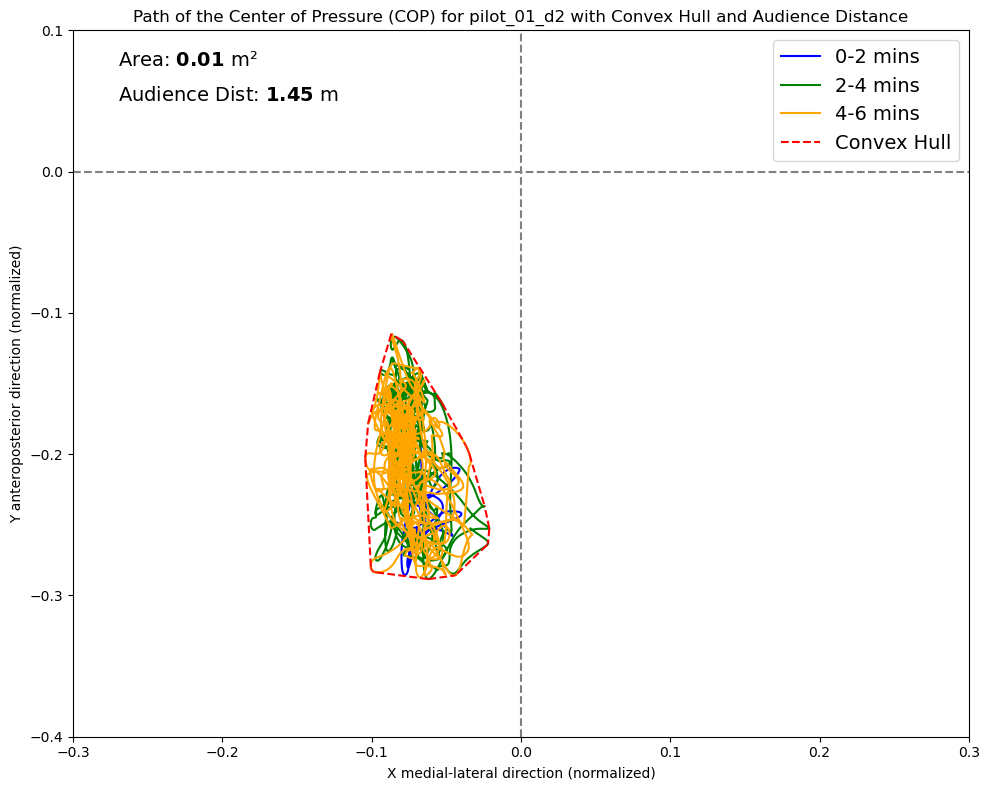

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_01_d2_BalanceBoard_results.csv
Processing participant session: pilot_01_d3
Loading file: pilot_01_d3__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_01_d3__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_01_d3__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_01_d3: 0.022053460443803085
Overall average distance to the audience for pilot_01_d3: 1.504490150550049


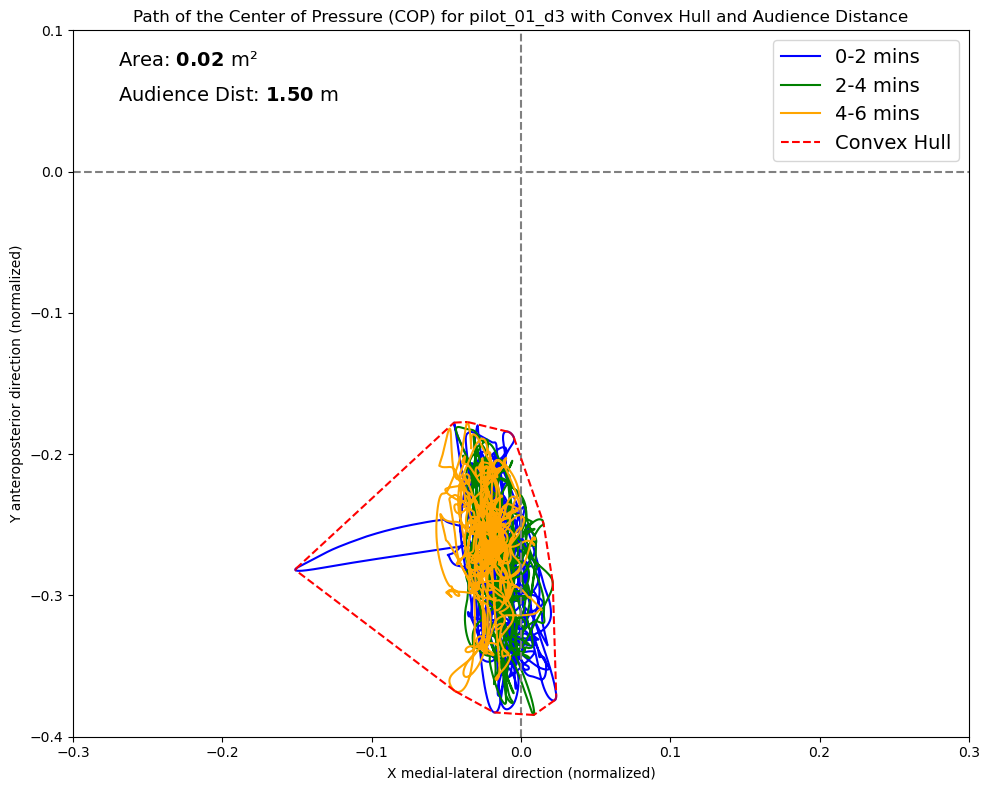

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_01_d3_BalanceBoard_results.csv
Processing participant session: pilot_02_d2
Loading file: pilot_02_d2__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_02_d2__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_02_d2__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_02_d2: 0.09979871148977781
Overall average distance to the audience for pilot_02_d2: 1.4939637441630647


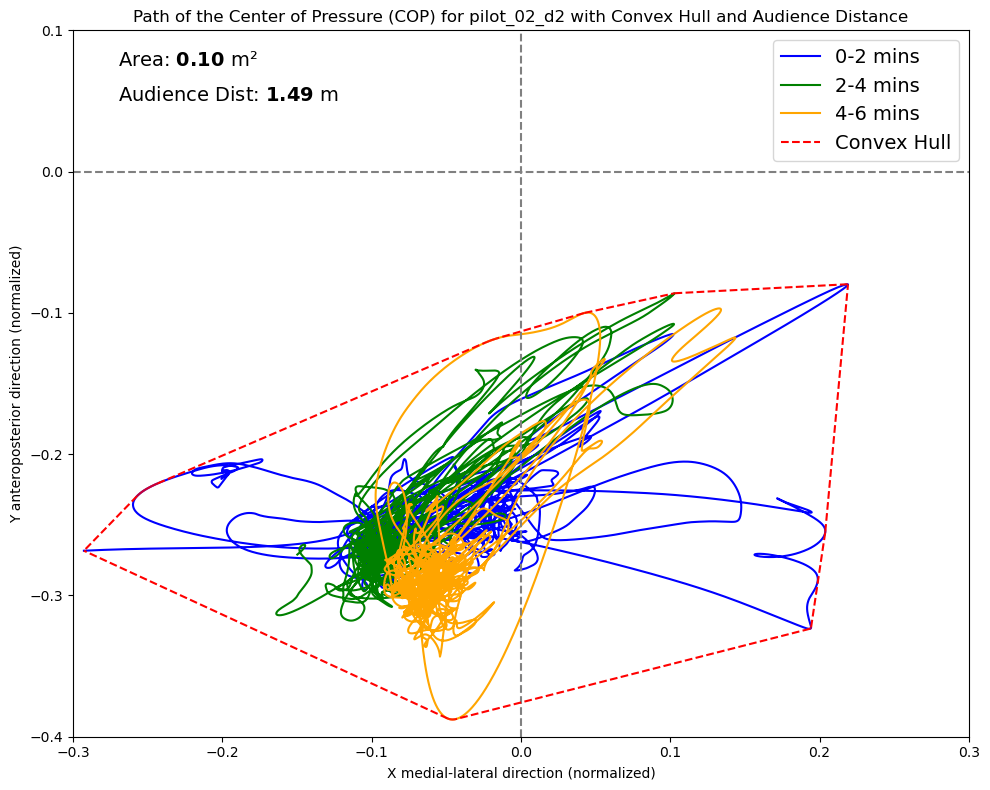

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_02_d2_BalanceBoard_results.csv
Processing participant session: pilot_02_d3
Loading file: pilot_02_d3__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_02_d3__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_02_d3__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_02_d3: 0.0343069356005903
Overall average distance to the audience for pilot_02_d3: 1.4974148579808286


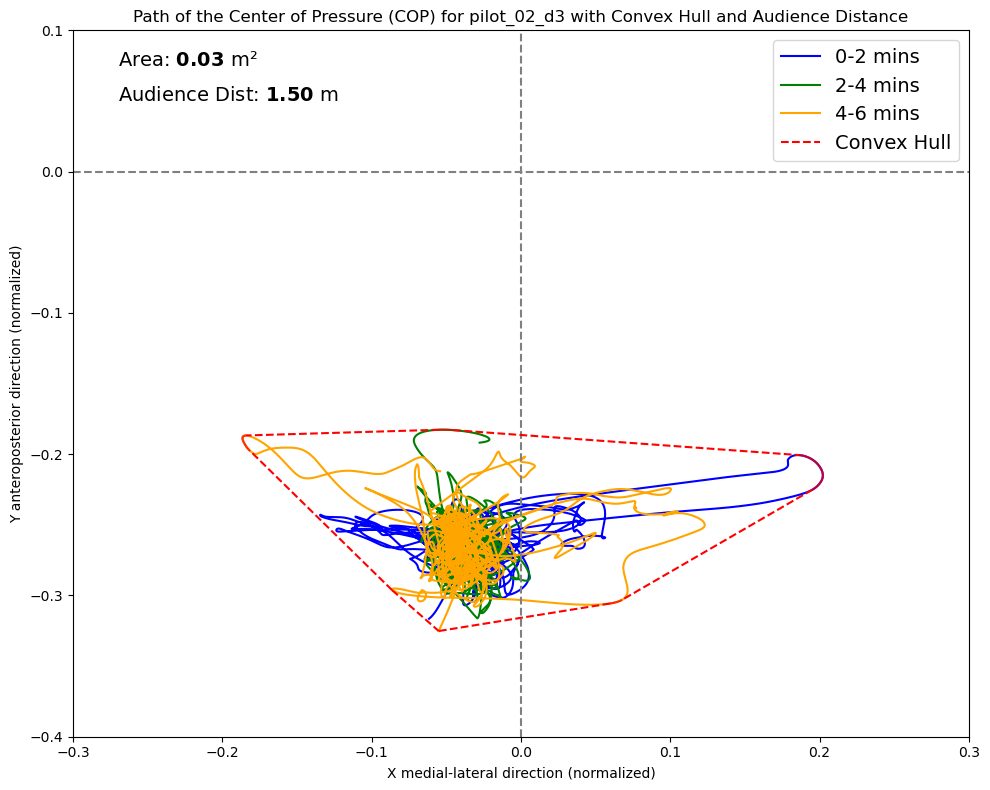

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_02_d3_BalanceBoard_results.csv
Processing participant session: pilot_04_d2
Loading file: pilot_04_d2__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_04_d2__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_04_d2__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_04_d2: 0.12617980370588794
Overall average distance to the audience for pilot_04_d2: 1.452371189693972


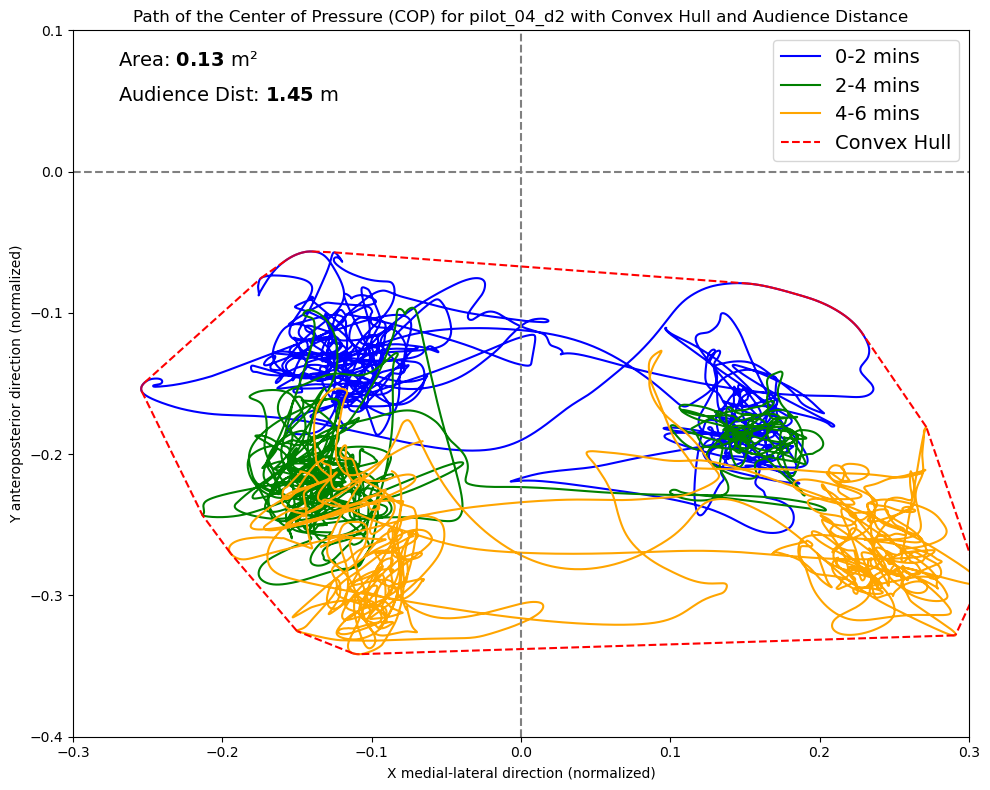

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_04_d2_BalanceBoard_results.csv
Processing participant session: pilot_05_d2
Loading file: pilot_05_d2__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_05_d2__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_05_d2__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_05_d2: 0.04416629486805259
Overall average distance to the audience for pilot_05_d2: 1.3097805604662258


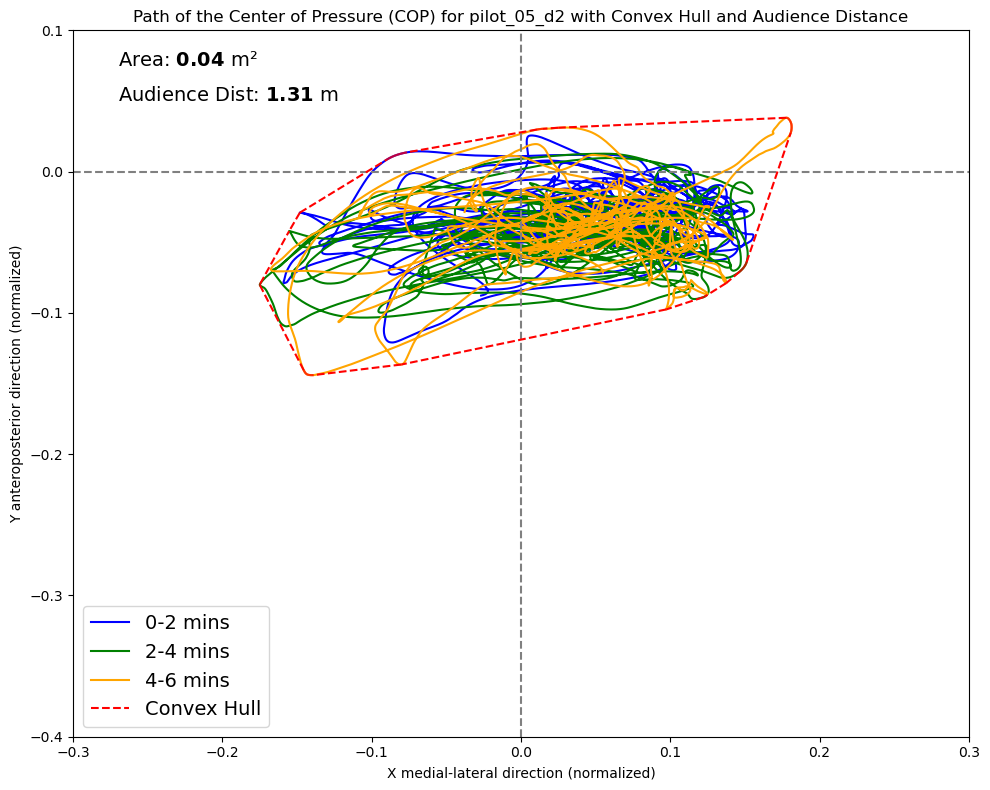

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_05_d2_BalanceBoard_results.csv
Processing participant session: pilot_06_d2
Loading file: pilot_06_d2__Speech_Start_SUD_1_BalanceBoard_processed.csv
Loading file: pilot_06_d2__SUD_1_End_SUD_BalanceBoard_processed.csv
Loading file: pilot_06_d2__SUD_2_End_SUD_BalanceBoard_processed.csv
Plotting COP for all segments...
Convex Hull (Sway Area) for pilot_06_d2: 0.018067123909950647
Overall average distance to the audience for pilot_06_d2: 1.2941133385420616


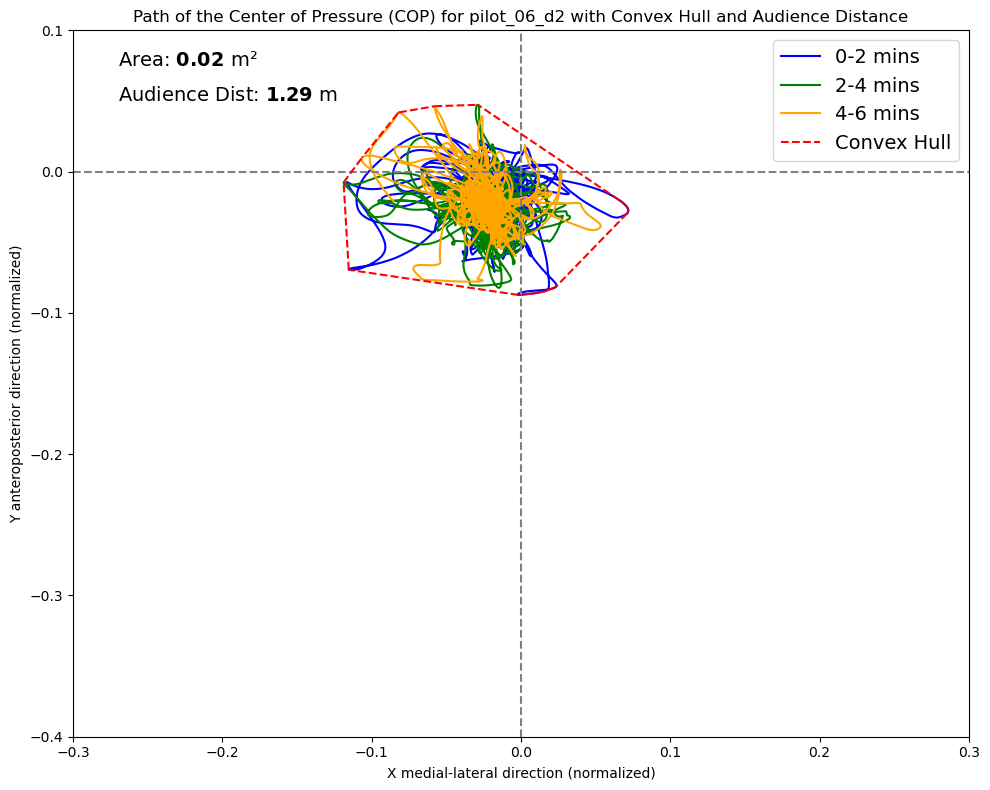

Results saved to: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\3_BALANCE_BOARD\COP_results\pilot_06_d2_BalanceBoard_results.csv
Processing completed successfully!


In [37]:

# List of participants and sessions to process
participants_sessions = [
    'pilot_01_d2', 'pilot_01_d3',
    'pilot_02_d2', 'pilot_02_d3',
    'pilot_04_d2', 'pilot_05_d2', 'pilot_06_d2'
]

# Loop through each participant and session
for participant_session in participants_sessions:
    print(f'Processing participant session: {participant_session}')

    # Find the three files corresponding to each participant session
    files = [
        file for file in os.listdir(output_COP_processed)
        if participant_session in file and file.endswith(".csv")
    ]
    
    # Sort files based on naming convention (Speech Start, SUD_1_End, SUD_2_End)
    files_sorted = sorted(files, key=lambda x: ("Speech_Start" in x, "SUD_1_End" in x, "SUD_2_End" in x), reverse=True)

    # Initialize lists to store COPX and COPY for all segments
    COPX_segments = []
    COPY_segments = []
    
    # Loop through the three files and load data
    for file in files_sorted:
        file_path = os.path.join(output_COP_processed, file)
        print(f'Loading file: {file}')
        
        # Load balance board filtered data
        bb = pd.read_csv(file_path)
        
        # Calculate the center of pressure (COP)
        COPX = (bb['right_forward_filtered'] + bb['right_back_filtered']) - (bb['left_forward_filtered'] + bb['left_back_filtered'])
        COPY = (bb['right_forward_filtered'] + bb['left_forward_filtered']) - (bb['right_back_filtered'] + bb['left_back_filtered'])

        # Normalize COP values to make them comparable between participants
        total_force = (bb['left_back_filtered'] + bb['right_back_filtered'] +
                       bb['right_forward_filtered'] + bb['left_forward_filtered'])
        COPX_normalized = COPX / total_force
        COPY_normalized = COPY / total_force

        # Append the normalized COP values to the segments list
        COPX_segments.append(COPX_normalized)
        COPY_segments.append(COPY_normalized)

    # Plot all three COP segments for the participant session
    print('Plotting COP for all segments...')
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'orange']
    labels = ['0-2 mins', '2-4 mins', '4-6 mins']

    for i, (COPX_segment, COPY_segment) in enumerate(zip(COPX_segments, COPY_segments)):
        plt.plot(COPX_segment, COPY_segment, color=colors[i], label=labels[i])

    # Combine all COP data points for convex hull and audience distance calculations
    COPX_combined = np.concatenate(COPX_segments)
    COPY_combined = np.concatenate(COPY_segments)
    points = np.column_stack((COPX_combined, COPY_combined))

    # Calculate the convex hull (sway area)
    hull = ConvexHull(points)
    sway_area = hull.volume  # Convex hull area (sway area)
    print(f'Convex Hull (Sway Area) for {participant_session}: {sway_area}')

    # Average Distance to Audience Members
    audience_positions = [(-1.0, 1), (0.0, 1), (1.0, 1)]  # Define positions of the 3 audience members

    # Calculate the distance from each audience member at each time point
    distances_to_audience = []
    for audience_x, audience_y in audience_positions:
        distance = np.sqrt((COPX_combined - audience_x) ** 2 + (COPY_combined - audience_y) ** 2)
        distances_to_audience.append(distance)

    # Convert the list of distances to a NumPy array
    distances_to_audience = np.array(distances_to_audience)

    # Combine distances by taking the average distance to all three audience members at each time point
    avg_distance_to_audience = np.mean(distances_to_audience, axis=0)

    # Calculate the overall average distance across the whole time series
    overall_avg_distance = np.mean(avg_distance_to_audience)
    print(f'Overall average distance to the audience for {participant_session}: {overall_avg_distance}')

    # Plot convex hull and average distance on the same plot as COP
    plt.xlabel('X medial-lateral direction (normalized)')
    plt.ylabel('Y anteroposterior direction (normalized)')
    plt.title(f'Path of the Center of Pressure (COP) for {participant_session} with Convex Hull and Audience Distance')
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    plt.ylim(-0.4, 0.1)
    plt.xlim(-0.3, 0.3)

    # Overlay the convex hull on the same plot
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=1.5, label='Convex Hull' if simplex[0] == hull.simplices[0][0] else "")
    
    # rect_x, rect_y = 0.03, 0.88  # Bottom-left corner of the rectangle (adjusted to fit the text position)
    # rect_width, rect_height = 0.6, 0.12  # Width and height of the rectangle to wrap both lines of text
    # rect = Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=0.5, edgecolor='black', facecolor='lightgray', alpha=0.5)
    # ax.add_patch(rect)

    # Add convex hull area and average distance to the audience on the plot
    plt.text(0.05, 0.95, f'Area: $\\bf{{{sway_area:.2f}}}$ m\u00B2', transform=plt.gca().transAxes, fontsize=14, color='black')
    plt.text(0.05, 0.9, f'Audience Dist: $\\bf{{{overall_avg_distance:.2f}}}$ m', transform=plt.gca().transAxes, fontsize=14, color='black')
    plt.legend(fontsize=14) 
    ax.set_aspect('auto') 
    plt.tight_layout()

    # Save the COP path figure with convex hull and audience distance
    cop_path_filename = f'{participant_session}_COP_all_segments_with_hull.png'
    cop_path_filepath = os.path.join(output_figure_results, cop_path_filename)
    plt.savefig(cop_path_filepath)
    plt.show()

    # Save the results (convex hull area and average distance) to a results CSV
    output_results_filename = f'{participant_session}_BalanceBoard_results.csv'
    output_results_filepath = os.path.join(output_COP_results, output_results_filename)

    results_data = pd.DataFrame({
        'convex_hull_area': [sway_area],
        'avg_distance_to_audience': [overall_avg_distance]
    })

    results_data.to_csv(output_results_filepath, index=False)
    print(f'Results saved to: {output_results_filepath}')

print('Processing completed successfully!')